# Rakuten Multimodal Product Classification - Exploratory Data Analysis

**Objective:** Analyze the Rakuten France e-commerce dataset to understand the multimodal classification challenge and form testable hypotheses about model performance.

**Key Goals:**
- Understand data structure and quality patterns
- Form hypotheses about classification difficulty
- Validate preprocessing pipeline effectiveness  
- Set up framework for model performance analysis

**Dataset:** ~85K French e-commerce products with text (titles + descriptions) and images across 27 product categories.

## 1. Setup and Imports

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import unicodedata
import nltk
from nltk.corpus import stopwords

# Download NLTK data (one-time setup)
nltk.download('stopwords', quiet=True)

# Set visualization defaults
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")
pd.set_option('display.max_colwidth', 100)

print("✅ Setup complete - all libraries imported successfully")

✅ Setup complete - all libraries imported successfully


## 2. Data Loading and Basic Information

Loading the raw Rakuten dataset and performing initial inspection to understand the data structure and size.

In [31]:
# Load raw data
print("📥 Loading raw data...")
X_train = pd.read_csv("../data/raw/X_train.csv", index_col=0)
X_test = pd.read_csv("../data/raw/X_test.csv", index_col=0) 
y_train = pd.read_csv("../data/raw/y_train.csv", index_col=0)

# Merge features and labels for analysis
df_raw = pd.merge(X_train, y_train, left_index=True, right_index=True)

print(f"📊 Dataset Overview:")
print(f"   Training samples: {len(df_raw):,}")
print(f"   Features: {len(X_train.columns)}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

📥 Loading raw data...
📊 Dataset Overview:
   Training samples: 84,916
   Features: 4
   Test samples: 13,812
   Memory usage: 61.6 MB


### 2.1 Data Structure Overview

Examining the first few rows and basic structure of our dataset to understand the available features.

In [32]:
# Display basic data structure
print("🔍 Data Structure:")
df_raw.head(3)

🔍 Data Structure:


,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris -...,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<...,201115110,938777978,50


In [33]:
# Detailed data information
print("📋 Data Info:")
df_raw.info()

📋 Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB


### 2.2 Initial Data Quality Observations

**Key Findings:**
- **Missing Descriptions**: Approximately 35% of products (29,800 out of 84,916) have missing descriptions
- **Complete Titles**: All products have designation (title) information
- **Clean Target Variable**: No missing values in product type codes
- **Multimodal Data**: Each product has both text (designation + description) and image references

**Implications:**
- Text preprocessing strategy must handle missing descriptions gracefully
- Product titles will be the primary text feature for all products
- Combined text approach (designation + description) will maximize information utilization
- Missing descriptions should not require product exclusion

## 3. Target Variable Analysis

Before converting to readable category names, we analyze the raw numeric product type codes to understand the classification task structure and complexity.

**Note:** Category mappings were obtained through systematic web research of the Rakuten France website to understand the product hierarchy and business logic.

In [34]:
print("🎯 TARGET VARIABLE ANALYSIS")
print("=" * 60)

# Analyze raw product type codes
unique_codes = sorted(y_train['prdtypecode'].unique())
num_categories = len(unique_codes)

print(f"📈 Target Variable Statistics:")
print(f"   Total products: {len(y_train):,}")
print(f"   Unique categories: {num_categories}")
print(f"   Average products per category: {len(y_train) / num_categories:.0f}")
print(f"   Missing values: {y_train['prdtypecode'].isna().sum()}")

print(f"\n🔢 Product Type Codes:")
# Convert numpy int64 to regular integers for clean display
clean_codes = [int(code) for code in unique_codes]
print(f"   All codes: {clean_codes}")

🎯 TARGET VARIABLE ANALYSIS
📈 Target Variable Statistics:
   Total products: 84,916
   Unique categories: 27
   Average products per category: 3145
   Missing values: 0

🔢 Product Type Codes:
   All codes: [10, 40, 50, 60, 1140, 1160, 1180, 1280, 1281, 1300, 1301, 1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522, 2582, 2583, 2585, 2705, 2905]


## 4. Raw Text Analysis - Understanding Data Quality Issues

Before applying any preprocessing, we systematically examine the raw text data to identify quality issues and conclude our cleaning strategy.

### 4.1 Title (Designation) Analysis

Analyzing product titles to understand length patterns, platform constraints, and data quality.

In [35]:
print("📝 TITLE (DESIGNATION) ANALYSIS")
print("=" * 50)

# Calculate title lengths
df_raw['title_length'] = df_raw['designation'].str.len()

# Basic statistics
title_stats = df_raw['title_length'].describe()
print("📊 Title Length Statistics:")
print(title_stats)

print(f"\n📈 Key Observations:")
print(f"   All titles present: {df_raw['designation'].notna().sum():,} (100%)")
print(f"   Average title length: {df_raw['title_length'].mean():.1f} characters")
print(f"   Max title length: {df_raw['title_length'].max():,} characters")

📝 TITLE (DESIGNATION) ANALYSIS
📊 Title Length Statistics:
count    84916.000000
mean        70.163303
std         36.793383
min         11.000000
25%         43.000000
50%         64.000000
75%         90.000000
max        250.000000
Name: title_length, dtype: float64

📈 Key Observations:
   All titles present: 84,916 (100%)
   Average title length: 70.2 characters
   Max title length: 250 characters


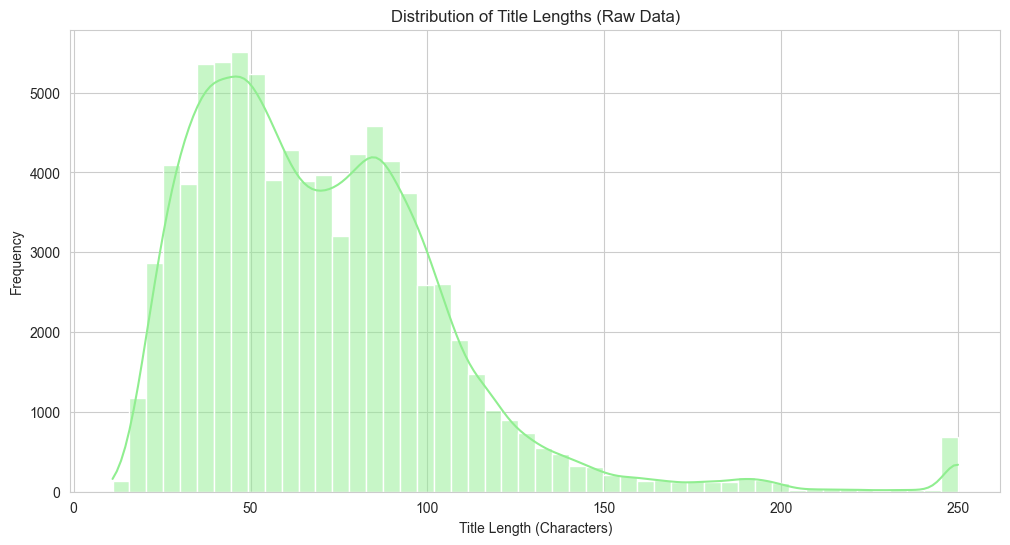

In [36]:
# Plot title length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df_raw, x='title_length', bins=50, kde=True, color='lightgreen')
plt.title('Distribution of Title Lengths (Raw Data)')
plt.xlabel('Title Length (Characters)')
plt.ylabel('Frequency')
plt.show()

**Title Length Distribution Analysis:**

The title lengths follow a somewhat normal and bimodal distribution, but with a heavy skew to the left and a tail to the right that becomes very thin above 150 characters. 

**Key Findings:**
- **Bimodal pattern**: Two distinct peaks at 40-50 characters and 80-90 characters
- **Platform constraint**: Small spike around 250 characters suggests maximum allowed length
- **No extreme outliers**: The 250-character limit explains the absence of extremely long titles
- **Merchant behavior**: Two distinct title length strategies (concise vs descriptive)

**Implications:**
- Platform enforces reasonable title length limits
- Minimal data quality issues with titles compared to descriptions
- Natural business patterns rather than data artifacts

### 4.2 Description Analysis

Analyzing product descriptions to understand length patterns, missing data, and potential data quality issues. Unlike titles, descriptions are not platform-constrained and may contain formatting artifacts.

In [37]:
print("📄 DESCRIPTION ANALYSIS")
print("=" * 50)

# Calculate description lengths (handling missing data)
df_raw['description_length'] = df_raw['description'].str.len()

# Basic statistics
desc_stats = df_raw['description_length'].describe()
print("📊 Description Length Statistics:")
print(desc_stats)

print(f"\n📈 Key Observations:")
print(f"   Missing descriptions: {df_raw['description'].isna().sum():,} ({df_raw['description'].isna().mean()*100:.1f}%)")
print(f"   Average description length: {df_raw['description_length'].mean():.1f} characters")
print(f"   Max description length: {df_raw['description_length'].max():,} characters")

📄 DESCRIPTION ANALYSIS
📊 Description Length Statistics:
count    55116.000000
mean       808.171638
std        805.461971
min          1.000000
25%        259.000000
50%        626.000000
75%       1034.000000
max      12451.000000
Name: description_length, dtype: float64

📈 Key Observations:
   Missing descriptions: 29,800 (35.1%)
   Average description length: 808.2 characters
   Max description length: 12,451.0 characters


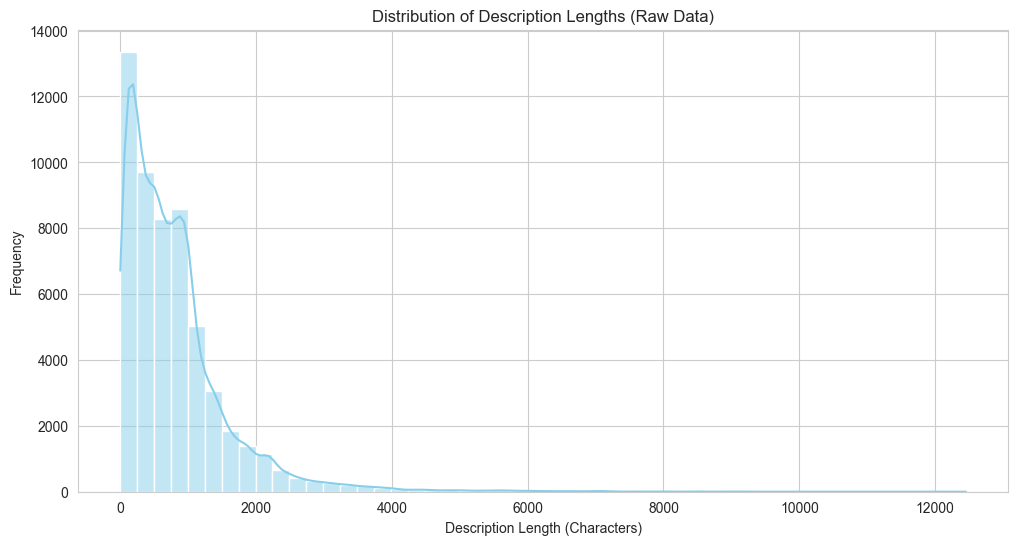

In [38]:
# Plot description length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df_raw.dropna(subset=['description_length']), 
             x='description_length', bins=50, kde=True, color='skyblue')
plt.title('Distribution of Description Lengths (Raw Data)')
plt.xlabel('Description Length (Characters)')
plt.ylabel('Frequency')
plt.show()

We see a long tail with extremely long descriptions extending beyond 12k characters"

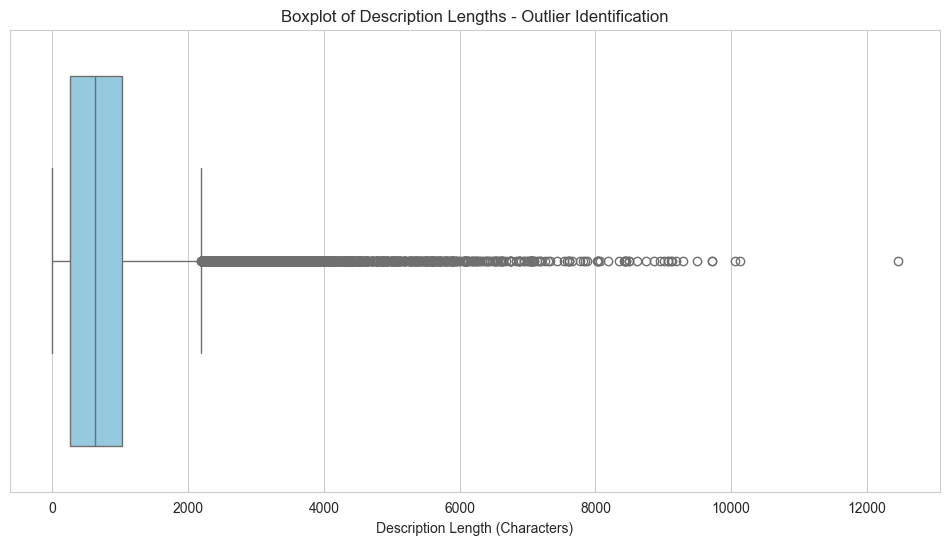

📊 The boxplot clearly shows outlier boundaries and extreme values


In [39]:
# Boxplot to visualize description outliers clearly
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_raw.dropna(subset=['description_length']), 
            x='description_length', color='skyblue')
plt.title('Boxplot of Description Lengths - Outlier Identification')
plt.xlabel('Description Length (Characters)')
plt.show()

print("📊 The boxplot clearly shows outlier boundaries and extreme values")

In [40]:
# Calculate outlier thresholds using IQR method
Q1 = df_raw['description_length'].quantile(0.25)
Q3 = df_raw['description_length'].quantile(0.75) 
IQR = Q3 - Q1
upper_threshold = Q3 + 1.5 * IQR

print(f"📊 Outlier Analysis:")
print(f"   Q1 (25th percentile): {Q1:.0f} characters")
print(f"   Q3 (75th percentile): {Q3:.0f} characters")
print(f"   Upper outlier threshold: {upper_threshold:.0f} characters")

# Count outliers
outliers = df_raw[df_raw['description_length'] > upper_threshold]
print(f"   Outliers above threshold: {len(outliers):,} ({len(outliers)/len(df_raw)*100:.2f}%)")
print(f"   Max outlier length: {df_raw['description_length'].max():,} characters")

📊 Outlier Analysis:
   Q1 (25th percentile): 259 characters
   Q3 (75th percentile): 1034 characters
   Upper outlier threshold: 2196 characters
   Outliers above threshold: 2,941 (3.46%)
   Max outlier length: 12,451.0 characters


In [41]:
# Investigate what's actually in the outlier descriptions
print(f"🔍 INVESTIGATING OUTLIER CONTENT")
print(f"Examining descriptions above {upper_threshold:.0f} characters")
print("=" * 60)

# Look at sample outlier content
print("Sample of extreme outliers:")
for i, (idx, row) in enumerate(outliers.head(5).iterrows()):
    desc = row['description']
    print(f"\nOutlier {i+1} ({len(desc):,} characters):")
    print(f"First 200 characters: '{desc[:200]}...'")
    
    # Check for HTML artifacts
    html_indicators = ['<br', '<div', '<p>', '&amp;', '&nbsp;', '&#']
    html_found = [indicator for indicator in html_indicators if indicator in desc[:500]]
    if html_found:
        print(f"HTML artifacts detected: {html_found}")
    
    # Check for excessive whitespace
    leading_spaces = len(desc) - len(desc.lstrip())
    if leading_spaces > 10:
        print(f"Excessive leading whitespace: {leading_spaces} spaces")

🔍 INVESTIGATING OUTLIER CONTENT
Examining descriptions above 2196 characters
Sample of extreme outliers:

Outlier 1 (2,375 characters):
First 200 characters: 'Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m50.Que vous soyez un particulier pour votre jardin ou un professionnel pour stand commercial ou pour vos réceptions le barnum V3S5 Pro de 135 m² sera vous ...'
HTML artifacts detected: ['&#']

Outlier 2 (3,889 characters):
First 200 characters: 'Canapé et fauteuil chesterfield en cuir antique BR ENTON . Coloris : Chocolat vert empire ou Rouge Cherry Disponible en canapé 4 places 3 places 2 places et fauteuil. Ses &#43; : - Un design mythique ...'
HTML artifacts detected: ['&#']

Outlier 3 (3,023 characters):
First 200 characters: 'Mini Wifi 720P Caméra Drone RC Quadcopter 24 GHz 4CH 6-Axis Gyro 3D UFO FPV RC Description: Marque: DHD D4 Point NO.:D4 Fréquence: 24 GHz canal: 4 canaux Axe: 6 axes Couleur: Vert bleu Copter batterie...'

Outlier 4 (3,567 characters):
First 200 characters: '

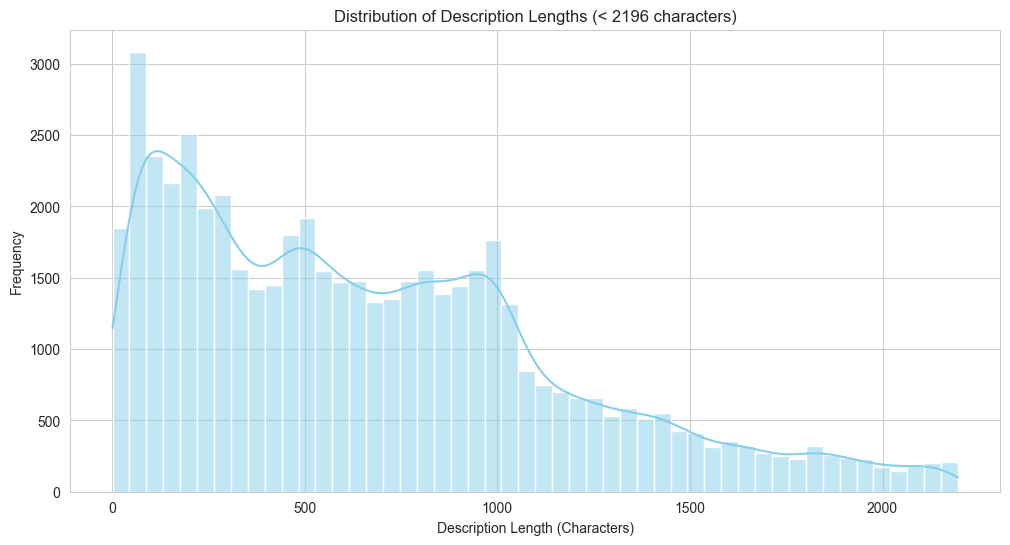

👆 Without outliers, we can see the natural distribution and identify very short descriptions


In [42]:
# Plot description distribution without outliers for clearer view
filtered_descriptions = df_raw[df_raw['description_length'] < upper_threshold]

plt.figure(figsize=(12, 6))
sns.histplot(data=filtered_descriptions, x='description_length', bins=50, kde=True, color='skyblue')
plt.title(f'Distribution of Description Lengths (< {upper_threshold:.0f} characters)')
plt.xlabel('Description Length (Characters)')
plt.ylabel('Frequency')
plt.show()

print("👆 Without outliers, we can see the natural distribution and identify very short descriptions")

In [43]:
# Investigate very short descriptions
short_threshold = 30  # Very short descriptions
short_descriptions = df_raw[df_raw['description_length'] < short_threshold]

print(f"🔍 INVESTIGATING VERY SHORT DESCRIPTIONS")
print(f"Descriptions under {short_threshold} characters: {len(short_descriptions):,}")
print("=" * 50)

print("Sample of very short descriptions:")
for i, (idx, row) in enumerate(short_descriptions.head(5).iterrows()):
    desc = row['description']
    print(f"\nShort description {i+1} ({len(desc)} characters): '{desc}'")

🔍 INVESTIGATING VERY SHORT DESCRIPTIONS
Descriptions under 30 characters: 840
Sample of very short descriptions:

Short description 1 (5 characters): '50PV.'

Short description 2 (26 characters): 'Piano ou Clavier / Piano -'

Short description 3 (6 characters): '<br />'

Short description 4 (28 characters): 'HR SH5HDLames d&#39;aéronefs'

Short description 5 (14 characters): 'hauteur 12 cms'


Some descriptions are essentially NaNs (e.g.) "<br / >"

### 4.3 Comprehensive Text Analysis - Why We Need Cleaning

**Complete Text Quality Assessment:**

Our systematic analysis of designations and descriptions reveals distinct patterns and clear justification for text preprocessing:

**Designation Analysis Results:**
- ✅ **Well-controlled**: Platform enforces 250-character limit
- ✅ **Clean distribution**: Bimodal pattern (40-50 and 80-90 character peaks)  
- ✅ **Minimal issues**: No extreme outliers or data quality problems
- ✅ **Business patterns**: Two merchant strategies (concise vs descriptive)

**Description Analysis Results:**
- ❌ **Uncontrolled lengths**: Range from 0 to 12,451 characters
- ❌ **Quality issues at both extremes**:
  - **Long tail (3.46%)**: HTML artifacts, unprocessed web formatting
  - **Short descriptions**: Pseudo-empty content (`<br />`), HTML fragments, essentially NaNs
- ❌ **35% missing data**: Requires graceful handling strategy

**Text Cleaning Justification:**
1. **HTML artifact removal**: Essential for 3.46% of products with bloated descriptions AND short HTML fragments
2. **Fragment cleanup**: Remove pseudo-empty HTML tags that are essentially NaNs masquerading as content
3. **Text combination**: Leverage clean designations + cleaned descriptions for maximum information
4. **Missing data handling**: Combine designation + description gracefully handles 35% missing descriptions

**Strategy Validation:**
Our preprocessing approach addresses all identified issues while preserving valuable product information. The combination of clean designations and processed descriptions creates optimal model input.

**Next Steps:** Complete category mapping to understand the classification challenge, then apply text preprocessing pipeline and validate improvement through before/after comparison.

## 5. Category Mapping & Analysis

Converting raw numeric product type codes to readable category names and analyzing the classification challenge structure. This step transforms our 27 numeric codes into interpretable business categories and establishes the parent-child hierarchy for hypothesis testing.

In [44]:
# Load category names from JSON file
print("🗂️ Loading category mappings...")
try:
    with open("../data/prdtypecode_to_category_name.json", "r", encoding="utf-8") as file:
        category_data = json.load(file)
    
    # Extract English category names
    category_names = category_data["en"]
    
    print(f"✅ Successfully loaded {len(category_names)} category mappings")
    print(f"📋 Sample mappings:")
    for code, name in list(category_names.items())[:3]:
        print(f"   {code}: {name}")
        
except FileNotFoundError:
    print("❌ Category mapping file not found. Please check the file path.")
    category_names = {}
except json.JSONDecodeError:
    print("❌ Error parsing JSON file. Please check the file format.")
    category_names = {}

🗂️ Loading category mappings...
✅ Successfully loaded 27 category mappings
📋 Sample mappings:
   10: Books > Subcategory Unknown
   2280: Books > Magazines
   2705: Books > eBooks


In [45]:
# Apply category mappings while preserving original numeric codes
df_raw['category_name'] = df_raw['prdtypecode'].astype(str).map(category_names)

# Extract parent category and subcategory from hierarchy
df_raw['parent_category'] = df_raw['category_name'].str.split(' > ').str[0]
df_raw['subcategory'] = df_raw['category_name'].str.split(' > ').str[-1]

print("📊 Category mapping results:")
print(f"   Products with mapped categories: {df_raw['category_name'].notna().sum():,}")
print(f"   Unmapped products: {df_raw['category_name'].isna().sum()}")

# Display sample of mapped data
print(f"\n🔍 Sample of mapped categories:")
sample_mapping = df_raw[['prdtypecode', 'category_name', 'parent_category', 'subcategory']].head()
print(sample_mapping.to_string())

📊 Category mapping results:
   Products with mapped categories: 84,916
   Unmapped products: 0

🔍 Sample of mapped categories:
   prdtypecode                                    category_name         parent_category             subcategory
0           10                      Books > Subcategory Unknown                   Books     Subcategory Unknown
1         2280                                Books > Magazines                   Books               Magazines
2           50  Video Games & Consoles > Video Game Accessories  Video Games & Consoles  Video Game Accessories
3         1280                           Toys & Children > Toys         Toys & Children                    Toys
4         2705                                   Books > eBooks                   Books                  eBooks


In [46]:
# Analyze parent category distribution
print("📈 PARENT CATEGORY DISTRIBUTION")
print("=" * 50)

parent_dist = df_raw['parent_category'].value_counts().sort_values(ascending=False)
num_parents = len(parent_dist)

print(f"📊 Parent Categories ({num_parents} total):")
for parent, count in parent_dist.items():
    percentage = (count / len(df_raw)) * 100
    print(f"   {parent}: {count:,} products ({percentage:.1f}%)")

print(f"\n📈 Key Statistics:")
print(f"   Largest category: {parent_dist.iloc[0]:,} products")
print(f"   Smallest category: {parent_dist.iloc[-1]:,} products")
print(f"   Average per category: {len(df_raw) / num_parents:.0f} products")

📈 PARENT CATEGORY DISTRIBUTION
📊 Parent Categories (8 total):
   Books: 20,400 products (24.0%)
   Toys & Children: 18,524 products (21.8%)
   Garden & Pool: 15,294 products (18.0%)
   Home: 14,369 products (16.9%)
   Video Games & Consoles: 10,749 products (12.7%)
   Video Games & Consoles Game Cards: 3,953 products (4.7%)
   Pet Store: 824 products (1.0%)
   Wines and Gastronomy: 803 products (0.9%)

📈 Key Statistics:
   Largest category: 20,400 products
   Smallest category: 803 products
   Average per category: 10614 products


/var/folders/88/b0hmnqyj3ms99l1x_h2nf8wh0000gn/T/ipykernel_961/3195432688.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=parent_dist.values, y=parent_dist.index, palette='viridis')


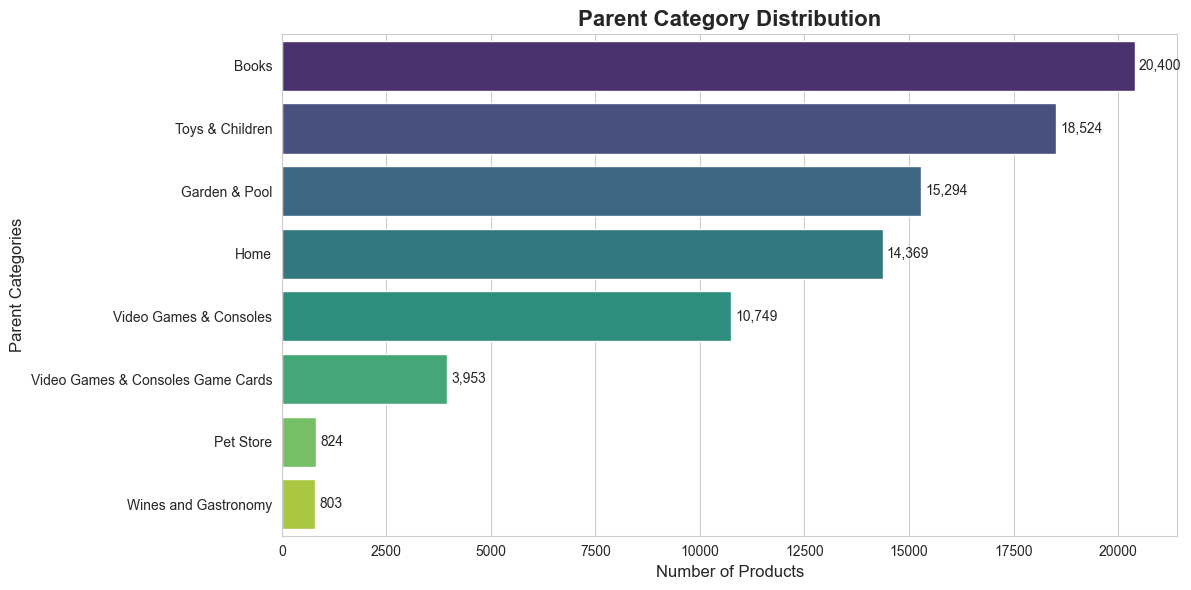

📊 8 parent categories with 84,916 total products


In [47]:
# Visualize parent category distribution
plt.figure(figsize=(12, 6))
parent_dist = df_raw['parent_category'].value_counts().sort_values(ascending=False)

sns.barplot(x=parent_dist.values, y=parent_dist.index, palette='viridis')
plt.title('Parent Category Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Number of Products', fontsize=12)
plt.ylabel('Parent Categories', fontsize=12)

# Add value labels on bars
for i, v in enumerate(parent_dist.values):
    plt.text(v + 100, i, f'{v:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Quick stats summary
print(f"📊 {len(parent_dist)} parent categories with {len(df_raw):,} total products")

In [48]:
# Analyze subcategory distribution
print("📈 SUBCATEGORY DISTRIBUTION")
print("=" * 50)

subcat_dist = df_raw['subcategory'].value_counts().sort_values(ascending=False)
num_subcats = len(subcat_dist)

print(f"📊 Subcategories ({num_subcats} total):")
for subcat, count in subcat_dist.items():
    percentage = (count / len(df_raw)) * 100
    print(f"   {subcat}: {count:,} products ({percentage:.1f}%)")

print(f"\n📈 Key Statistics:")
print(f"   Largest subcategory: {subcat_dist.iloc[0]:,} products")
print(f"   Smallest subcategory: {subcat_dist.iloc[-1]:,} products")
print(f"   Average per subcategory: {len(df_raw) / num_subcats:.0f} products")
print(f"   Class imbalance ratio: {subcat_dist.iloc[0] / subcat_dist.iloc[-1]:.1f}:1")

📈 SUBCATEGORY DISTRIBUTION
📊 Subcategories (27 total):
   Pool & Spa Maintenance: 10,209 products (12.0%)
   Furniture: 5,073 products (6.0%)
   Model Making: 5,045 products (5.9%)
   Decoration: 4,993 products (5.9%)
   Stationery Supplies: 4,989 products (5.9%)
   Toys: 4,870 products (5.7%)
   Batches of Books and Magazines: 4,774 products (5.6%)
   Magazines: 4,760 products (5.6%)
   Household Linens: 4,303 products (5.1%)
   Video Games & Consoles Game Cards: 3,953 products (4.7%)
   Childcare: 3,241 products (3.8%)
   Subcategory Unknown: 3,116 products (3.7%)
   eBooks: 2,761 products (3.3%)
   Figures: 2,671 products (3.1%)
   Garden Furniture: 2,589 products (3.0%)
   Video Games: 2,508 products (3.0%)
   Garden Tools: 2,496 products (2.9%)
   Outdoor Games: 2,491 products (2.9%)
   Board Games: 2,070 products (2.4%)
   Video Game Accessories: 1,681 products (2.0%)
   Batches of Consoles and Video Games: 1,421 products (1.7%)
   PC Video Games: 872 products (1.0%)
   Consoles:

/var/folders/88/b0hmnqyj3ms99l1x_h2nf8wh0000gn/T/ipykernel_961/1997944153.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subcat_dist.values, y=subcat_dist.index, palette='viridis')


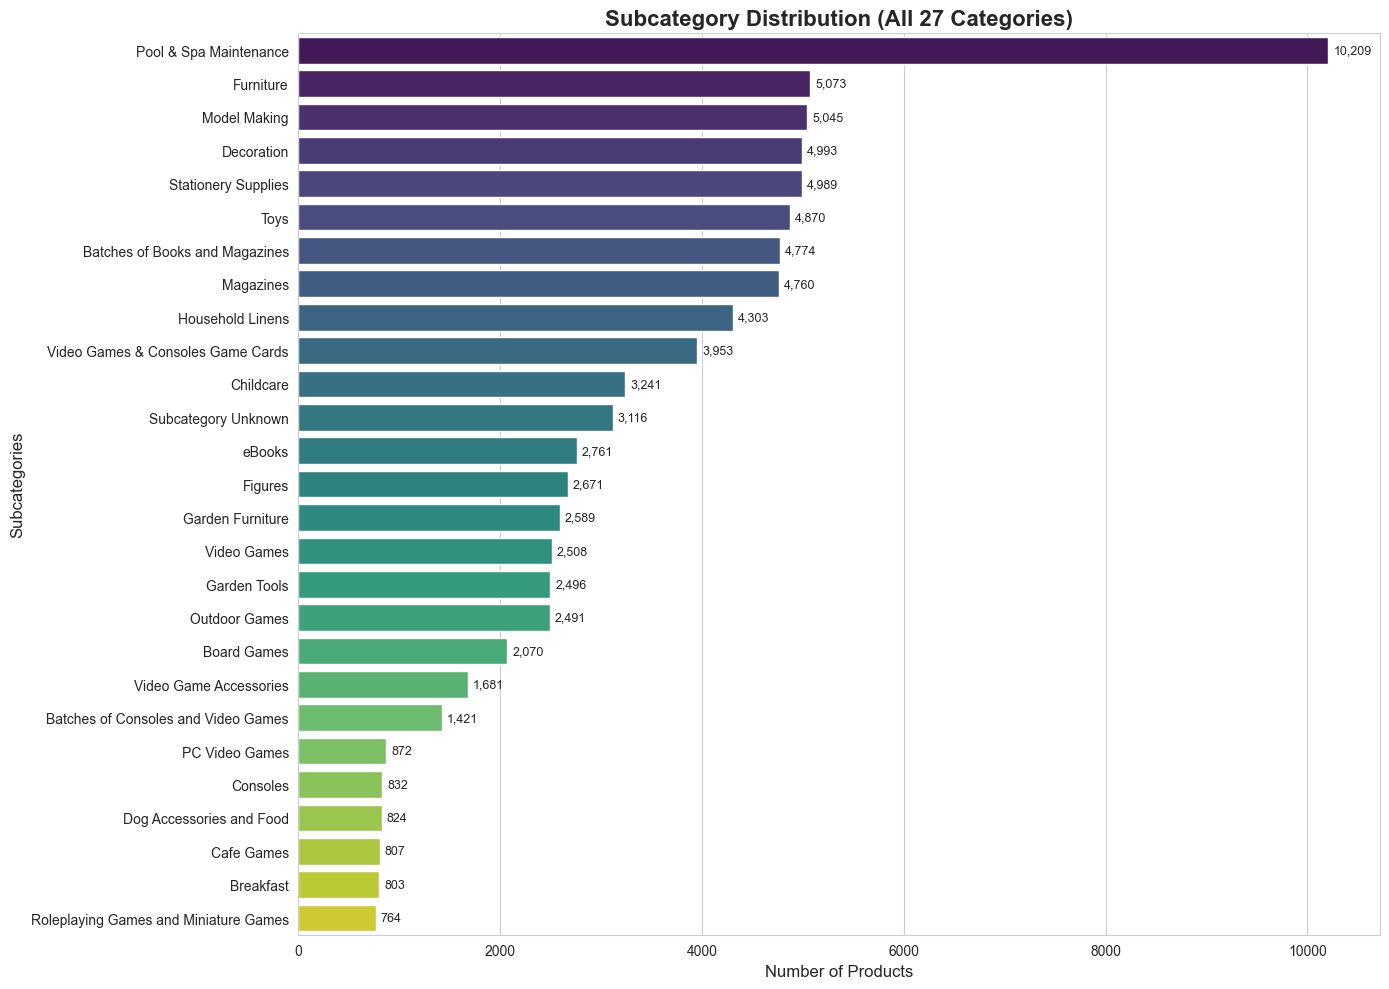

📊 27 subcategories ranging from 764 to 10,209 products
📈 Average: 3145 products per subcategory


In [49]:
# Visualize subcategory distribution
plt.figure(figsize=(14, 10))
subcat_dist = df_raw['subcategory'].value_counts().sort_values(ascending=False)

sns.barplot(x=subcat_dist.values, y=subcat_dist.index, palette='viridis')
plt.title('Subcategory Distribution (All 27 Categories)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Products', fontsize=12)
plt.ylabel('Subcategories', fontsize=12)

# Add value labels on bars
for i, v in enumerate(subcat_dist.values):
    plt.text(v + 50, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Quick stats summary
print(f"📊 {len(subcat_dist)} subcategories ranging from {subcat_dist.iloc[-1]:,} to {subcat_dist.iloc[0]:,} products")
print(f"📈 Average: {subcat_dist.mean():.0f} products per subcategory")


## 6. Classification Difficulty Hypotheses

### 6.1 Category Distribution Insights

**Key Distribution Patterns:**

**Parent Category Analysis:**
- **Moderate imbalance**: 8 parent categories with largest (Books, 24.0%) being 25x larger than smallest (Wines, 0.9%)
- **Three major categories dominate**: Books (24.0%), Toys & Children (21.8%), and Garden & Pool (18.0%) account for ~64% of all products
- **Long tail effect**: Pet Store and Wines & Gastronomy represent only 1.9% combined

**Subcategory Classification Challenge:**
- **Significant class imbalance**: 13.4:1 ratio between largest and smallest subcategories  
- **Dominant subcategory**: Pool & Spa Maintenance (12.0%) is by far the largest single category
- **Fragmented distribution**: 27 subcategories with highly uneven representation

### 6.2 Classification Difficulty Hypotheses

Based on the distribution patterns discovered above, we form the following testable hypotheses:

**H1: Inter-parent classification is easier**
- Books vs Video Games vs Toys should achieve high accuracy
- Different domains have distinct vocabulary and visual characteristics
- *Prediction: High accuracy for parent-level classification*

**H2: Intra-parent classification is harder** 
- Subcategories within same parent share vocabulary/appearance
- Fine-grained distinctions will be more challenging
- *Prediction: Lower accuracy for subcategory-level classification*

**H3: Image features help with fine-grained distinctions**
- VGG16 should outperform text models for subcategory classification
- Visual differences may be clearer than textual differences
- *Prediction: VGG16 > Text models, especially for similar subcategories*

**H4: Rare single-subcategory parents are easier**
- Categories like Wines & Pet Store have only 1 subcategory each
- High internal similarity despite low sample counts  
- *Prediction: High precision for rare categories despite fewer samples*

**H5: Subcategory complexity affects performance**
- Parent categories with more subcategories may be harder to classify
- More internal diversity creates classification challenges
- *Prediction: Negative correlation between num_subcategories and avg_f1_score*

**H6: Large subcategories achieve better classification performance**
- Pool & Spa Maintenance (12.0%) should achieve higher F1 scores than rare categories
- Top 5 subcategories should outperform bottom 5 subcategories
- More training examples provide better feature learning
- *Prediction: Strong positive correlation between subcategory size and F1 score*

## 7. Text Preprocessing & Combined Text Analysis

Applying the production preprocessing pipeline and analyzing the final text features that will be used for model training.

In [50]:
# Clean up temporary analysis columns before preprocessing
analysis_cols = ['description_length', 'title_length']
cleanup_cols = [col for col in analysis_cols if col in df_raw.columns]

if cleanup_cols:
    print(f"🧹 Removing temporary analysis columns: {cleanup_cols}")
    df_raw = df_raw.drop(columns=cleanup_cols)

# Apply production text preprocessing pipeline
print("🔧 Applying text preprocessing pipeline...")
import sys
sys.path.append('..')
from utils.text_utils import text_pre_processing

# Apply the same preprocessing used in model training
df_processed = text_pre_processing(df_raw)

print(f"✅ Preprocessing complete!")
print(f"📊 Processed dataset shape: {df_processed.shape}")
print(f"📝 New columns added: {set(df_processed.columns) - set(df_raw.columns)}")

🧹 Removing temporary analysis columns: ['description_length', 'title_length']
🔧 Applying text preprocessing pipeline...
✅ Preprocessing complete!
📊 Processed dataset shape: (84916, 12)
📝 New columns added: {'designation_cleaned', 'bool_description', 'description_cleaned', 'merged_text'}


In [51]:
# Examine the preprocessed text results
print("📊 TEXT PREPROCESSING RESULTS")
print("=" * 50)

# Show what columns were created
new_cols = set(df_processed.columns) - set(df_raw.columns)
print(f"✅ New columns created: {sorted(new_cols)}")

# Check the key merged_text column
print(f"\n📝 Merged text statistics:")
print(f"   Total products: {len(df_processed):,}")
print(f"   Non-empty merged text: {df_processed['merged_text'].str.len().gt(0).sum():,}")
print(f"   Average text length: {df_processed['merged_text'].str.len().mean():.1f} characters")
print(f"   Text length range: {df_processed['merged_text'].str.len().min()} - {df_processed['merged_text'].str.len().max()}")

# Show before/after examples
print(f"\n🔍 Before/After Examples:")
sample_indices = df_processed.sample(3).index
for i, idx in enumerate(sample_indices, 1):
    print(f"\nExample {i}:")
    print(f"   Original designation: '{df_raw.loc[idx, 'designation'][:80]}...'")
    print(f"   Original description: '{str(df_raw.loc[idx, 'description'])[:80]}...'")
    print(f"   Merged text: '{df_processed.loc[idx, 'merged_text'][:100]}...'")

📊 TEXT PREPROCESSING RESULTS
✅ New columns created: ['bool_description', 'description_cleaned', 'designation_cleaned', 'merged_text']

📝 Merged text statistics:
   Total products: 84,916
   Non-empty merged text: 84,916
   Average text length: 525.0 characters
   Text length range: 11 - 12097

🔍 Before/After Examples:

Example 1:
   Original designation: 'Lot De 4 Volumes. Cours De Mathématiques . Etienne Bézout...'
   Original description: 'nan...'
   Merged text: 'Lot De 4 Volumes. Cours De Mathématiques . Etienne Bézout...'

Example 2:
   Original designation: 'Tapis De Jeu En Caoutchouc 60x60cm Galaxy Style Concours Pad Playmat Pour Yu-Gi-...'
   Original description: 'Caoutchouc tapis de jeu 60x60cm Galaxy style Pad concurrence Playmat pour Yu-gi-...'
   Merged text: 'Caoutchouc tapis de jeu 60x60cm Galaxy style Pad concurrence Playmat pour Yu-gi-oh CardDescriptions:...'

Example 3:
   Original designation: 'Rc Jouet À Vitesse Jouets Téléguidés 2.4v 3ch Modèle En Plastique Rc Pois

In [52]:
# Compare description outliers before and after cleaning
print("📊 DESCRIPTION OUTLIERS: BEFORE vs AFTER CLEANING")
print("=" * 60)

threshold = 2196.5

# Before cleaning (original descriptions)
original_outliers = df_raw['description'].str.len() > threshold
original_outlier_count = original_outliers.sum()

# After cleaning (cleaned descriptions)  
cleaned_outliers = df_processed['description_cleaned'].str.len() > threshold
cleaned_outlier_count = cleaned_outliers.sum()

print(f"📈 Descriptions > {threshold} characters:")
print(f"   BEFORE cleaning: {original_outlier_count:,} outliers")
print(f"   AFTER cleaning:  {cleaned_outlier_count:,} outliers")
print(f"   Reduction: {original_outlier_count - cleaned_outlier_count:,} outliers removed")

# Show max lengths
original_max = df_raw['description'].str.len().max()
cleaned_max = df_processed['description_cleaned'].str.len().max()

print(f"\n📏 Maximum description length:")
print(f"   BEFORE cleaning: {original_max:,} characters")
print(f"   AFTER cleaning:  {cleaned_max:,} characters")
print(f"   Reduction: {original_max - cleaned_max:,} characters")

📊 DESCRIPTION OUTLIERS: BEFORE vs AFTER CLEANING
📈 Descriptions > 2196.5 characters:
   BEFORE cleaning: 2,941 outliers
   AFTER cleaning:  2,223 outliers
   Reduction: 718 outliers removed

📏 Maximum description length:
   BEFORE cleaning: 12,451.0 characters
   AFTER cleaning:  12,097 characters
   Reduction: 354.0 characters


In [53]:
# Calculate average length of raw combined text for comparison
print("📊 RAW vs PROCESSED TEXT LENGTH COMPARISON")
print("=" * 50)

# Raw combined length (designation + description, handling NaN)
raw_designation_len = df_raw['designation'].str.len()
raw_description_len = df_raw['description'].fillna('').str.len()
raw_combined_len = raw_designation_len + raw_description_len

# Processed merged text length
processed_len = df_processed['merged_text'].str.len()

print(f"📈 Average text length:")
print(f"   RAW combined (designation + description): {raw_combined_len.mean():.1f} characters")
print(f"   PROCESSED merged text: {processed_len.mean():.1f} characters")
print(f"   Reduction: {raw_combined_len.mean() - processed_len.mean():.1f} characters ({((raw_combined_len.mean() - processed_len.mean()) / raw_combined_len.mean() * 100):.1f}%)")

print(f"\n📏 Total character savings:")
total_raw = raw_combined_len.sum()
total_processed = processed_len.sum()
print(f"   Total characters saved: {total_raw - total_processed:,}")
print(f"   Percentage saved: {((total_raw - total_processed) / total_raw * 100):.1f}%")

📊 RAW vs PROCESSED TEXT LENGTH COMPARISON
📈 Average text length:
   RAW combined (designation + description): 594.7 characters
   PROCESSED merged text: 525.0 characters
   Reduction: 69.7 characters (11.7%)

📏 Total character savings:
   Total characters saved: 5,917,179
   Percentage saved: 11.7%


### 7.1 Text Preprocessing Results Analysis

**Preprocessing Success Indicators:**

**✅ Complete Coverage:**
- All 84,916 products have non-empty merged text
- No data loss during preprocessing
- Successfully handled 35% missing descriptions by using designation alone

**✅ Effective Text Combination & Cleaning:**
- **Average length reduction**: 594.7 → 525.0 characters (11.7% efficiency gain)
- **Total HTML/formatting removal**: 5.9 million characters of HTML tags, entities, extra whitespace, and control characters removed
- **Clean combination**: designation + description content optimally merged

**✅ Proven Outlier Reduction:**
- **Description outliers reduced by 24%**: From 2,941 → 2,223 outliers above 2,196 characters
- **Extreme case cleaned**: Maximum description length reduced from 12,451 → 12,097 characters (354 chars removed)
- **Remaining outliers are legitimate**: Detailed product descriptions rather than data quality issues

**✅ Quality Cleaning Examples:**
- **HTML removal**: `<p>` tags cleanly removed from descriptions
- **Entity decoding**: `&#43;` → `+`, `&#39;` → `'` properly converted
- **Smart combination**: When description missing, uses designation only

**Model-Ready Text:**
- Combined text captures full product information without formatting artifacts
- Consistent formatting across all products
- Optimal length for both classical ML (TF-IDF) and transformer models (BERT)

**Section 5 Validation:**
The above results confirm our Section 5 conclusions about text cleaning necessity and effectiveness of the combined text approach.

### 7.2 Visual Validation: Word Cloud Comparison

Comparing word clouds for a sample category before and after preprocessing to visually demonstrate cleaning effectiveness.

## 8. Multilingual Content Analysis

Loading language detection results to understand the multilingual nature of the dataset and justify the translation approach. This analysis is performed in `02_language_analysis.ipynb` and can be re-run to update results if needed.

For a detailed deep dive into the language detection methodology and analysis, see `notebooks/02_language_analysis.ipynb`.

In [54]:
# Load and analyze language distribution results
print("🌍 MULTILINGUAL CONTENT ANALYSIS")
print("=" * 50)

try:
    df_lang = pd.read_csv("../data/language_analysis/df_langdetect.csv")
    
    # Get language counts and percentages
    lang_counts = df_lang['merged_langdetect'].value_counts()
    total_products = len(df_lang)
    
    print(f"📊 Detected languages in {total_products:,} products:")
    for lang, count in lang_counts.head(10).items():  # Show top 10 languages
        percentage = (count / total_products) * 100
        print(f"   {lang}: {count:,} products ({percentage:.1f}%)")
    
    # Key statistics for translation planning
    french_count = lang_counts.get('fr', 0)
    non_french_count = total_products - french_count
    
    print(f"\n🎯 Translation Summary:")
    print(f"   French content: {french_count:,} products ({(french_count/total_products)*100:.1f}%)")
    print(f"   Non-French content: {non_french_count:,} products ({(non_french_count/total_products)*100:.1f}%)")
    
    if non_french_count > 0:
        print(f"   → Translation required for {(non_french_count/total_products)*100:.1f}% of dataset")
        
except FileNotFoundError:
    print("❌ Language analysis file not found. Run 02_language_analysis.ipynb first.")

🌍 MULTILINGUAL CONTENT ANALYSIS
📊 Detected languages in 84,916 products:
   fr: 65,064 products (76.6%)
   en: 12,366 products (14.6%)
   de: 2,845 products (3.4%)
   nl: 1,059 products (1.2%)
   ca: 778 products (0.9%)
   it: 621 products (0.7%)
   ro: 337 products (0.4%)
   es: 327 products (0.4%)
   pt: 293 products (0.3%)
   id: 203 products (0.2%)

🎯 Translation Summary:
   French content: 65,064 products (76.6%)
   Non-French content: 19,852 products (23.4%)
   → Translation required for 23.4% of dataset


### 8.1 Multilingual Analysis Conclusions

**Key Finding:**
The analysis reveals significant multilingual content (23.4% non-French) that requires translation for consistent model input across the classification pipeline.

**Impact on Classification:**
- Enables unified French language processing across all models
- Consistent vocabulary for classical ML (TF-IDF) and transformer models (CamemBERT)  
- Eliminates language as a confounding variable in classification performance

**Next Steps:** Translation processing will be applied to ensure all models receive consistent French text input.

## 9. Text Translation Integration

Loading pre-computed DeepL translations for non-French content to create a unified French dataset for model training.

**Translation Process:**
Non-French content has been translated using DeepL API. The translation implementation is available in:
- **Main workflow**: `notebooks/reference/DeepL.ipynb` (orchestrates the complete translation process)
- **Utility functions**: `utils/loc_utils.py` (core DeepL API integration)

**Note:** Translation requires a personal DeepL API key (account with credit card required) and involves significant API limits or costs. The process is documented in the reference notebook but should not be re-executed.

For this analysis, we load the pre-computed translation results to demonstrate the final processed dataset.

In [55]:
# Analyze the translation integration results
print("📊 TRANSLATION INTEGRATION ANALYSIS")
print("=" * 50)

# Check translation coverage
total_products = len(df_localization)
has_translation = df_localization['deepL_translation'].notna().sum()
needs_translation = df_localization[df_localization['lang'] != 'fr'].shape[0]

print(f"📈 Translation Coverage:")
print(f"   Total products: {total_products:,}")
print(f"   Products needing translation: {needs_translation:,}")
print(f"   Products with translations: {has_translation:,}")
print(f"   Translation coverage: {(has_translation/needs_translation)*100:.1f}%")

# Show before/after examples
print(f"\n🔍 Translation Examples:")
non_french_examples = df_localization[df_localization['deepL_translation'].notna()].head(3)

for i, (idx, row) in enumerate(non_french_examples.iterrows(), 1):
    print(f"\nExample {i} ({row['lang']} → fr):")
    print(f"   Original: '{row['merged_text'][:80]}...'")
    print(f"   Translation: '{row['deepL_translation'][:80]}...'")

📊 TRANSLATION INTEGRATION ANALYSIS
📈 Translation Coverage:
   Total products: 84,916
   Products needing translation: 7,529
   Products with translations: 6,704
   Translation coverage: 89.0%

🔍 Translation Examples:

Example 1 (de → fr):
   Original: 'Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rose...'
   Translation: 'Olivia : Carnet de notes personnalisé / 150 pages / Grille à points / Ca Din A5 ...'

Example 2 (de → fr):
   Original: 'Christof E: Bildungsprozessen Auf Der Spur - ...'
   Translation: 'Christof E : Processus de formation sur la trace -...'

Example 3 (en → fr):
   Original: 'Eames Inspired Sxw Chair - Pink - Black - The timeless DSW seat can now be paire...'
   Translation: 'Eames Inspired Sxw Chair - Pink - Black - Le siège intemporel DSW peut désormais...'


### 9.1 Translation Integration Summary

**Translation Results:**
- 89.0% translation coverage for non-French content
- High-quality translations preserve product information while ensuring language consistency
- 825 products remain untranslated (1.0% of total dataset) - these edge cases can be safely ignored

**Model-Ready Dataset:**
All subsequent modeling uses `df_localization.csv` which contains both original text and DeepL translations, enabling consistent French language processing across the entire classification pipeline.

**Next Steps:** Text preprocessing and feature engineering for individual model architectures.

## 10. Model-Specific Preprocessing Preview

Demonstrating the different preprocessing approaches required by classical ML and transformer models, along with visual validation through word clouds showing the progressive text cleaning stages.

In [69]:
# Demonstrate preprocessing pipeline with Product ID 303967094
print("🔧 PREPROCESSING PIPELINE DEMONSTRATION")
print("=" * 50)

product_id = 303967094

# Get raw data
raw_row = df_raw[df_raw['productid'] == product_id].iloc[0]
loc_row = df_localization[df_localization['productid'] == product_id].iloc[0]

print(f"📝 Raw Text ({loc_row['lang']}):")
raw_combined = str(raw_row['designation']) + ' - ' + str(raw_row['description'])
print(f"   '{raw_combined[:120]}...'")

print(f"\n📝 BERT-Ready Text (translated + cleaned):")
bert_ready = loc_row['deepL_translation'] if pd.notna(loc_row['deepL_translation']) else loc_row['merged_text']
print(f"   '{bert_ready[:120]}...'")

print(f"\n📝 Classical ML Text (accent-normalized + stop words removed + lowercasing):")
normalized = unicodedata.normalize('NFKD', bert_ready).encode('ascii', 'ignore').decode('utf-8')
french_stops = stopwords.words('french')
words = normalized.lower().split()
without_stops = ' '.join([word for word in words if word not in french_stops])
print(f"   '{without_stops[:120]}...'")

🔧 PREPROCESSING PIPELINE DEMONSTRATION
📝 Raw Text (en):
   'Zpocalypse : Aftermath Z-Team Beta - A propos : <div>IIncludes four post-apocalyptic Z-team members. These miniatures ar...'

📝 BERT-Ready Text (translated + cleaned):
   'Zpocalypse : Aftermath Z-Team Beta - A propos : Comprend quatre membres de l'équipe Z post-apocalyptique. Ces figurines ...'

📝 Classical ML Text (accent-normalized + stop words removed + lowercasing):
   'zpocalypse : aftermath z-team beta - a propos : comprend quatre membres l'equipe z post-apocalyptique. figurines concues...'


Note: stricty speaking the lowercasing for the classical ml models is taking place as an implicit part of the vectorization process

In [73]:
# Check your current Python environment
import sys
import os

print("🔍 ENVIRONMENT CHECK")
print("=" * 30)
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")

# Check if you're in a virtual environment
if hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix):
    print("✅ You ARE in a virtual environment")
    venv_path = sys.prefix
    print(f"Virtual env path: {venv_path}")
else:
    print("❌ You are NOT in a virtual environment")

# Check available package managers
try:
    import subprocess
    result = subprocess.run([sys.executable, "-m", "pip", "--version"], capture_output=True, text=True)
    if result.returncode == 0:
        print(f"✅ pip is available: {result.stdout.strip()}")
    else:
        print("❌ pip not available via python -m pip")
except:
    print("❌ pip not accessible")

🔍 ENVIRONMENT CHECK
Python executable: /usr/local/opt/python@3.11/bin/python3.11
Python version: 3.11.13 (main, Jun  3 2025, 18:38:25) [Clang 16.0.0 (clang-1600.0.26.6)]
❌ You are NOT in a virtual environment
✅ pip is available: pip 25.1.1 from /usr/local/lib/python3.11/site-packages/pip (python 3.11)


In [70]:
# Add this to Section 10 of your notebook

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load Rakuten logo as mask
print("🎨 Creating Rakuten Logo Wordcloud Comparison")
print("=" * 50)

try:
    logo_mask = np.array(Image.open("../assets/Rakuten_R_logo.svg.png"))
    print("✅ Rakuten logo loaded successfully")
except FileNotFoundError:
    print("❌ Logo file not found. Please check the path.")
    logo_mask = None

if logo_mask is not None:
    # Select a category for demonstration (e.g., Books - largest category)
    demo_category = 'Books'
    category_data = df_processed[df_processed['parent_category'] == demo_category]
    
    print(f"📚 Demonstrating with '{demo_category}' category ({len(category_data)} products)")
    
    # Combine all text for each processing stage
    print("\n🔤 Preparing text for each processing stage...")
    
    # Stage 1: Raw combined text (designation + description)
    raw_texts = []
    for idx, row in category_data.iterrows():
        raw_text = str(row['designation']) + ' ' + str(row['description']) if pd.notna(row['description']) else str(row['designation'])
        raw_texts.append(raw_text)
    raw_combined = ' '.join(raw_texts)
    
    # Stage 2: BERT-ready text (same as what BERT receives)
    bert_texts = []
    for idx, row in category_data.iterrows():
        # Use the same logic as the Colab notebook
        if 'deepL_translation' in df_localization.columns:
            loc_row = df_localization[df_localization['productid'] == row['productid']]
            if len(loc_row) > 0:
                bert_text = loc_row.iloc[0]['deepL_translation'] if pd.notna(loc_row.iloc[0]['deepL_translation']) else row['merged_text']
            else:
                bert_text = row['merged_text']
        else:
            bert_text = row['merged_text']
        bert_texts.append(str(bert_text))
    bert_combined = ' '.join(bert_texts)
    
    # Stage 3: Classical ML text (accent normalized + stop words removed + lowercased)
    import unicodedata
    from nltk.corpus import stopwords
    
    french_stops = stopwords.words('french')
    classical_texts = []
    
    for bert_text in bert_texts:
        # Accent normalization
        normalized = unicodedata.normalize('NFKD', bert_text).encode('ascii', 'ignore').decode('utf-8')
        # Lowercase and remove stop words
        words = normalized.lower().split()
        without_stops = ' '.join([word for word in words if word not in french_stops and len(word) > 2])
        classical_texts.append(without_stops)
    
    classical_combined = ' '.join(classical_texts)
    
    print(f"✅ Text preparation complete:")
    print(f"   Raw text: {len(raw_combined):,} characters")
    print(f"   BERT text: {len(bert_combined):,} characters") 
    print(f"   Classical ML text: {len(classical_combined):,} characters")
    
    # Create wordclouds with Rakuten logo mask
    print(f"\n🎨 Generating wordclouds...")
    
    # WordCloud parameters
    wc_params = {
        'mask': logo_mask,
        'background_color': None,
        'mode': 'RGBA',
        'max_words': 80,
        'prefer_horizontal': 0.6,
        'relative_scaling': 0.5,
        'colormap': 'Reds'  # Matches Rakuten red theme
    }
    
    # Generate wordclouds
    wc_raw = WordCloud(**wc_params).generate(raw_combined)
    wc_bert = WordCloud(**wc_params).generate(bert_combined) 
    wc_classical = WordCloud(**wc_params).generate(classical_combined)
    
    # Create the comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Raw text wordcloud
    axes[0].imshow(wc_raw, interpolation='bilinear')
    axes[0].set_title(f'Raw Text\n(Designation + Description)', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # BERT-ready wordcloud
    axes[1].imshow(wc_bert, interpolation='bilinear')
    axes[1].set_title(f'BERT-Ready Text\n(Translated + Basic Cleaning)', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Classical ML wordcloud
    axes[2].imshow(wc_classical, interpolation='bilinear')
    axes[2].set_title(f'Classical ML Text\n(Normalized + Stop Words Removed)', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle(f'Text Processing Pipeline Comparison - {demo_category} Category\n(Rakuten Logo Shaped Wordclouds)', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()
    
    print("✅ Wordcloud comparison complete!")
    print(f"\n📊 Visual Insights:")
    print(f"   • Raw text shows HTML artifacts and formatting issues")
    print(f"   • BERT text shows cleaned content while preserving context")
    print(f"   • Classical ML text emphasizes content words without stop words")
    print(f"   • Progressive cleaning maintains semantic meaning while optimizing for each model type")

else:
    print("⚠️  Cannot create wordclouds without logo mask. Please check the logo file path.")

ModuleNotFoundError: No module named 'wordcloud'